In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy
from decimal import *
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
import threading
import numpy as np
import datetime

In [3]:
import itertools

In [4]:
number_of_nodes = 10

In [5]:
def calcImportance_pre(stake):

    # get total stake per node
    stakePerNode = [(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

def setupStake(
        # Number of nodes in the network. This number can be changed to test with small and large network size
        numNodes= number_of_nodes,
        # the minimum number of channels a node can open
        minChannelsPerNode=2,
        # the maximum number of channels a node can open 
        maxChannelsPerNode=10,
        minFundsPerNode=1,
        maxFundsPerNode=1000,
        tokensPerTicket=0.1
    ):

    stake = [[0 for i in range(numNodes)] for j in range(numNodes)]
    listStakePerChannel = []
    avg_stake_list = []
    index_list = []
    for x in range(numNodes-4):
        # each node is given a random funding amount
        myFunds = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode

        
        # get random number of channels per node
        myChannels = int(numpy.random.rand() * (maxChannelsPerNode - minChannelsPerNode + 1) + minChannelsPerNode)

        # This value represents the amount each node stakes in their channel
        # It is computed as the number of funds a node has divided by number of channels they open
        stakePerChannel = myFunds / myChannels
        stakePerChannel = int(stakePerChannel / tokensPerTicket) * tokensPerTicket
        
        # Creats a list of stakePerChannel
        listStakePerChannel.append(stakePerChannel)

        # Identifying the maximum stake
        maxListStakePerChannel = max(listStakePerChannel)
        
        # Identifying the "position" of the stake - which node initiated 
        index = listStakePerChannel.index(maxListStakePerChannel)
        index_list.append(index)
        index_max = max(index_list)

        # fund channels by writing into stake matrix
        for c in range(myChannels):
            # TODO: this does not prevent a node from opening a channel to the same counterparty multiple times
            counterparty = int(numpy.random.rand() * (numNodes - 5))

            # cannot open channel to self - keep diagonal of matrix at 0
            if counterparty >= x:
                counterparty = counterparty + 1
            stake[x][counterparty] = stakePerChannel
        
        sum_stake = sum([sum(stake[li]) for li in range(numNodes-4)])
        avg_stake = sum_stake/(numNodes-4)
        
    importance_score = calcImportance_pre(stake)
    
    
    #calculating imporance score
    importance_max = max(importance_score)
    index_of_importance = numpy.where(importance_score == importance_max)
    importance_max_i = index_of_importance[0][0]
    
    strategy_fund = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode       
 
    #non_random node 3, strategy: placing all the stake on the node, which has the highest importance score
    stake[numNodes-4][importance_max_i] = strategy_fund
    
    #non_random node 1, strategy: spreading the stakes equally between the channels
    for b in range(numNodes-4):
        stake[numNodes-3][b] = strategy_fund/(numNodes-4)
        
    #non_random node 2, strategy: spreading the stakes between the channels based on their proportionate share of the sum of stakes
    for r in range(numNodes-4):
        stake[numNodes-2][r] = importance_score[r]/sum(importance_score)*strategy_fund
    
    stake = [[Decimal(i) for i in j] for j in stake]
    
    return stake

In [10]:
initial_stake = setupStake()

In [11]:
def calcImportance(stake):

    # get total stake per node
    stakePerNode = [Decimal(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

In [12]:
initial_importance = calcImportance(initial_stake)

In [13]:
def selectChannel(weights, weightIndexToNodeLUT):
    """
    Randomly selects a counterparty based on weights according to a LUT
    Returns the node id (or -1 if none could be found)
    Parameters
    ----------
    weights: a list of weights to be used for normalizing the random selection
    weightIndexToNodeLUT: a LUT translating the weights list to node ids
    """
    rand = numpy.random.rand()
    totalWeight = sum(weights)
    sumWeights = 0
    counterparty = -1
    for i in enumerate(weights):
        sumWeights += i[1]
        if totalWeight == 0:
           sumWeights = 0
        else:
            if sumWeights / totalWeight >= rand:
               counterparty = weightIndexToNodeLUT[i[0]]
               break;
    return counterparty

In [14]:
def randomPickWeightedByImportance(importance):
    channel = selectChannel(importance, [i for i in range(len(importance))])
    return channel

In [15]:
def openChannels(stake, importance):
        #print("opening channels")
        numOpenChannels = 0
        channelcount = 1
        ctn = number_of_nodes-1
        openchannelid = [ctn]
        tokensPerChannel = 10
        # add own id to avoid self-staking
        while (numOpenChannels < channelcount):

            # do not open channels to same counterparty multiple times
            tmpImportance = list(importance)
            for i in range(len(importance)):
                if i in openchannelid:
                    tmpImportance[i] = 0

            newChannel = randomPickWeightedByImportance(tmpImportance)
            
            if (newChannel == -1):
                print("ERROR: could not find a counterparty to open the channel to!")
                # TODO: here we should try again but this time including 0 importance nodes
            else:
                #print("opening channel to node ", newChannel)
                stake[ctn][newChannel] = stake[ctn][newChannel] + 10
                openchannelid.append(newChannel)
            # if opening channels didn't work we still want this loop to terminate
            numOpenChannels = numOpenChannels + 1
        
        return openchannelid

In [16]:
 def sendPacket(stake, importance):
        #print("sending packet")

        # persist importance list between attempts so that dead ends can be removed
        importanceAttempts = importance.copy()
        attemptsPerTick = 10
        hops = 3
        numPlayers = 4
        ctNodeId = number_of_nodes-1

        for a in range(attemptsPerTick):
            nextNodeIndex = ctNodeId
            pathIndices = [nextNodeIndex]

            # try to find a path
            for j in range(hops):
                # reset importance
                importanceTmp = importanceAttempts.copy()
                #hoprsim.printArray1d(importanceTmp, 1)

                # remove importance entries for nodes to which current hop has no open channels
                # this is used in the path selection for the next hop
                for i in range(numPlayers):
                    if stake[nextNodeIndex][i] == 0 :
                        importanceTmp[i] = 0

                # prevent loops in path by removing existing nodes on path from list
                for i in pathIndices:
                    importanceTmp[i] = 0

                #hoprsim.printArray1d(importanceTmp, 1)
                nextNodeIndex = randomPickWeightedByImportance(importanceTmp)
                if nextNodeIndex == -1:
                    break # stop looking for path if no next node could be found
                pathIndices.append(nextNodeIndex)

            #print("Found path: ", pathIndices)
            if len(pathIndices) < hops + 1:
                print('ignored path')
            else:
                return pathIndices
            # then facilitate they payout to each node
            # but only as long as the edge is valid (new earnings + existing earnings <= counter party stake)

In [17]:
def iteration_with_fixed_stake(stake, importance):    
    opening_count = []
    opening_list = []
    sending_count = []
    sending_list = []
    
    for _ in range(1000):
        #running the openChannel function 1000 times 
        #creating a list from the outputs
        opening_channel_to = openChannels(stake, importance)
        opening_count.append(opening_channel_to)
        sending_packet_to = sendPacket(stake, importance)
        sending_count.append(sending_packet_to)
    
    #orginizing the list in a dataframe - where each opening/sending position refers to a column 
    opening_pd = pd.DataFrame(opening_count)
    sending_pd = pd.DataFrame(sending_count)

    #summing up the opening appearance by node
    for h in range(len(opening_pd.columns)):
        #counting the value by opening positions (e.g. - how many times showep up the given node as the first node of openings)
        openings = opening_pd[h].value_counts()
        opening_list.append(openings)
    #organizing the list in a new dataframe
    opening_list = pd.concat(opening_list).to_frame().reset_index()
    opening_list.columns = ['node_opening_to', 'sum_opening']
      
      #summing up the sending appearance by node
    for k in range(len(sending_pd.columns)):
        #counting the value by opening positions (e.g. - how many times showep up the given node as the first node of openings)
        sendings = sending_pd[k].value_counts()
        sending_list.append(sendings)
    #organizing the list in a new dataframe
    sending_list = pd.concat(sending_list).to_frame().reset_index()
    sending_list.columns = ['node_sending_to', 'sum_sending']
    
    
    #summing up by nodes
    opening_list = opening_list.groupby(['node_opening_to']).sum()
    sending_list = sending_list.groupby(['node_sending_to']).sum()
    stake_ct = stake[number_of_nodes-1]
    
    output = pd.concat([opening_list, sending_list], axis=1)
    output['stake'] = stake_ct
    
    return output

In [18]:
iteration_list = []
total_stake_pernode = []

def iteration_with_random_setup():
    for _ in range(100):
        # creating a new stake matrix and calculating it's importance
        ini_stake = setupStake()
        ini_importance = calcImportance(ini_stake)
        #calculating the sum of stakes per node 
        for p in range(len(ini_stake)):
            j = sum(ini_stake[p])
            total_stake_pernode.append(j)
            total_stake_pernode_df = pd.DataFrame(total_stake_pernode)
        #running the "number of openings" function
        output = iteration_with_fixed_stake(ini_stake, ini_importance)
        #creating a list from the iterations
        iteration_list.append(output)
        iteration_list_df = pd.concat(iteration_list)
        iteration_list_df = iteration_list_df.reset_index(drop=False)
    
    #merging the sum of the stakes and the ineration dataframe 
    iteration_output = pd.concat([iteration_list_df, total_stake_pernode_df], axis=1)
    iteration_output = iteration_output.rename(columns={'index': 'node_number', 0: 'total_stake_per_node'})
    return iteration_output


In [19]:
iteration_random = iteration_with_random_setup()
iteration_random

,node_number,sum_opening,sum_sending,stake,total_stake_per_node
0,0,41.0,107,410,130.8000000000000113686837722
1,1,87.0,228,870,395.4000000000000341060513164
2,2,54.0,169,540,267.6000000000000227373675444
3,3,71.0,235,710,338.7000000000000170530256583
4,4,72.0,228,720,343.2000000000000454747350886
...,...,...,...,...,...
995,5,231.0,576,2310,774.0
996,6,76.0,283,760,452.7921161102717064750322606
997,7,140.0,477,1400,452.7921161102717348967416910
998,8,177.0,482,1770,452.7921161102716922641775455


In [20]:
#removing the CT node
df = iteration_random[iteration_random["node_number"] != number_of_nodes-1]
df

,node_number,sum_opening,sum_sending,stake,total_stake_per_node
0,0,41.0,107,410,130.8000000000000113686837722
1,1,87.0,228,870,395.4000000000000341060513164
2,2,54.0,169,540,267.6000000000000227373675444
3,3,71.0,235,710,338.7000000000000170530256583
4,4,72.0,228,720,343.2000000000000454747350886
...,...,...,...,...,...
994,4,112.0,390,1120,409.0000000000000568434188609
995,5,231.0,576,2310,774.0
996,6,76.0,283,760,452.7921161102717064750322606
997,7,140.0,477,1400,452.7921161102717348967416910


In [21]:
conditions = [
    (df['node_number'] == number_of_nodes-2),
    (df['node_number'] == number_of_nodes-3),
    (df['node_number'] == number_of_nodes-4),
    (df['node_number'] < number_of_nodes-4)
    ]

values = ['weighted', 'equal_spread', 'all_in', 'random']

df['node_runners'] = np.select(conditions, values)

df.head()

C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,node_number,sum_opening,sum_sending,stake,total_stake_per_node,node_runners
0,0,41.0,107,410,130.8000000000000113686837722,random
1,1,87.0,228,870,395.4000000000000341060513164,random
2,2,54.0,169,540,267.6000000000000227373675444,random
3,3,71.0,235,710,338.7000000000000170530256583,random
4,4,72.0,228,720,343.2000000000000454747350886,random


In [22]:
df["total_stake_per_node_m"] = df["total_stake_per_node"].apply(lambda x: float(x))
df["sum_sending_m"] = df["sum_sending"].apply(lambda x: float(x))

C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szany\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


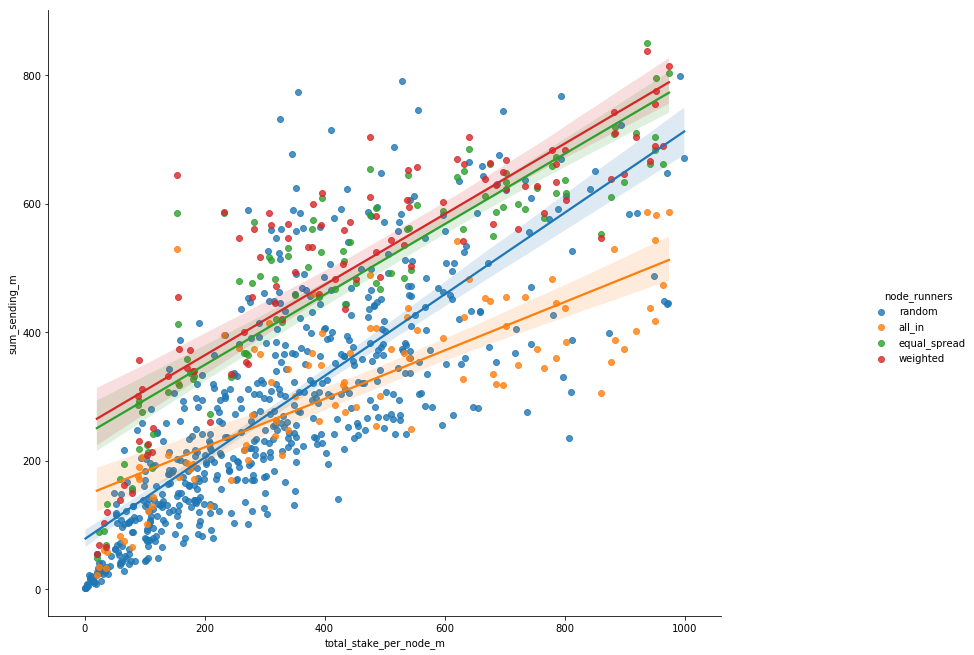

In [23]:
sns.lmplot(x="total_stake_per_node_m", y="sum_sending_m", hue="node_runners", data=df)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

C:\Users\szany\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


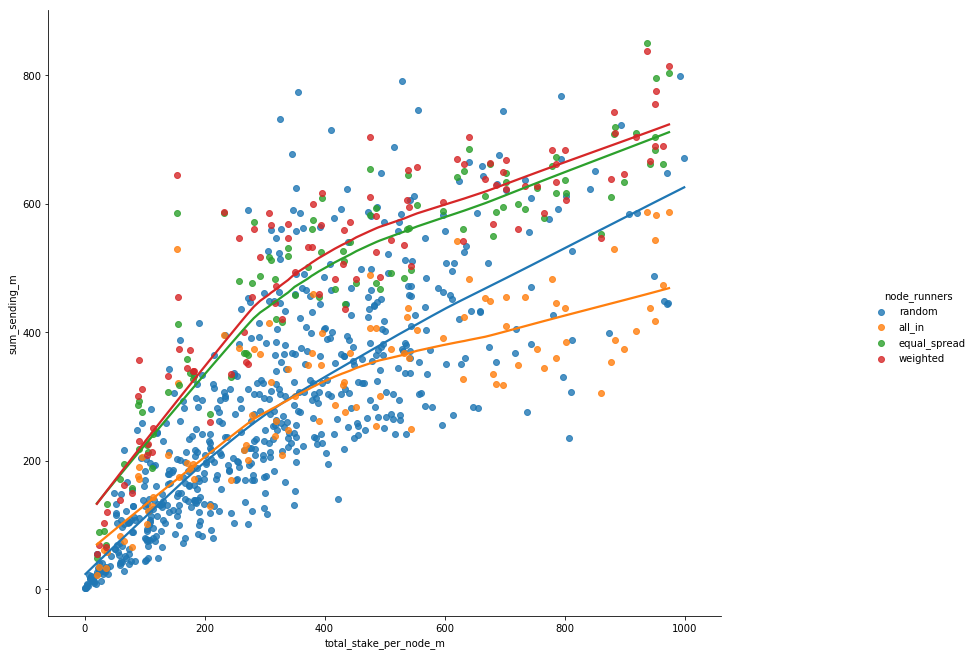

In [25]:
sns.lmplot(x="total_stake_per_node_m", y="sum_sending_m", hue="node_runners", data=df, lowess=True)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

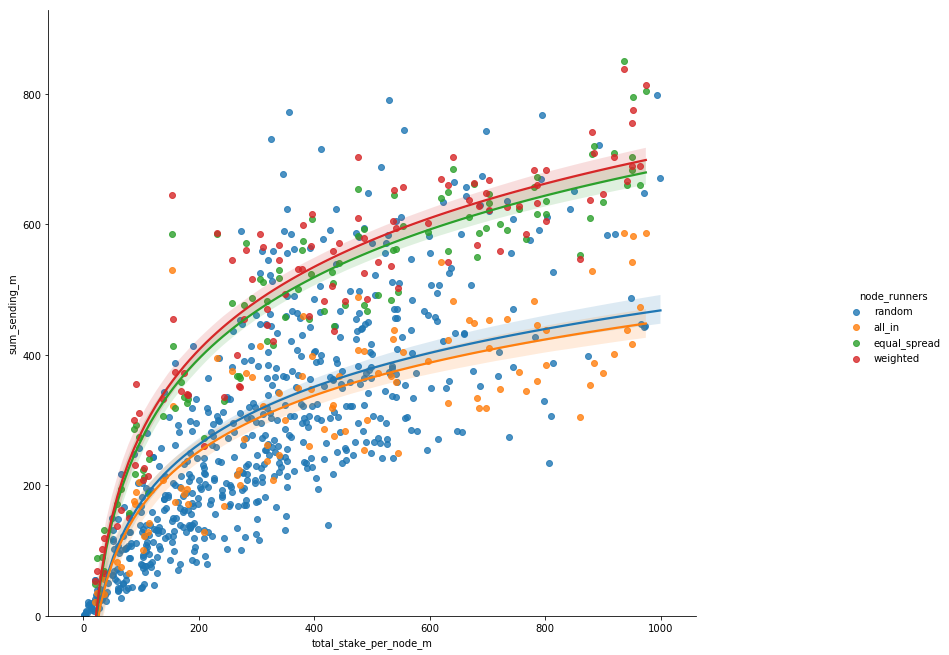

In [24]:
sns.lmplot(x="total_stake_per_node_m", y="sum_sending_m", hue="node_runners", data=df, logx=True)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.ylim(0,)
plt.show()

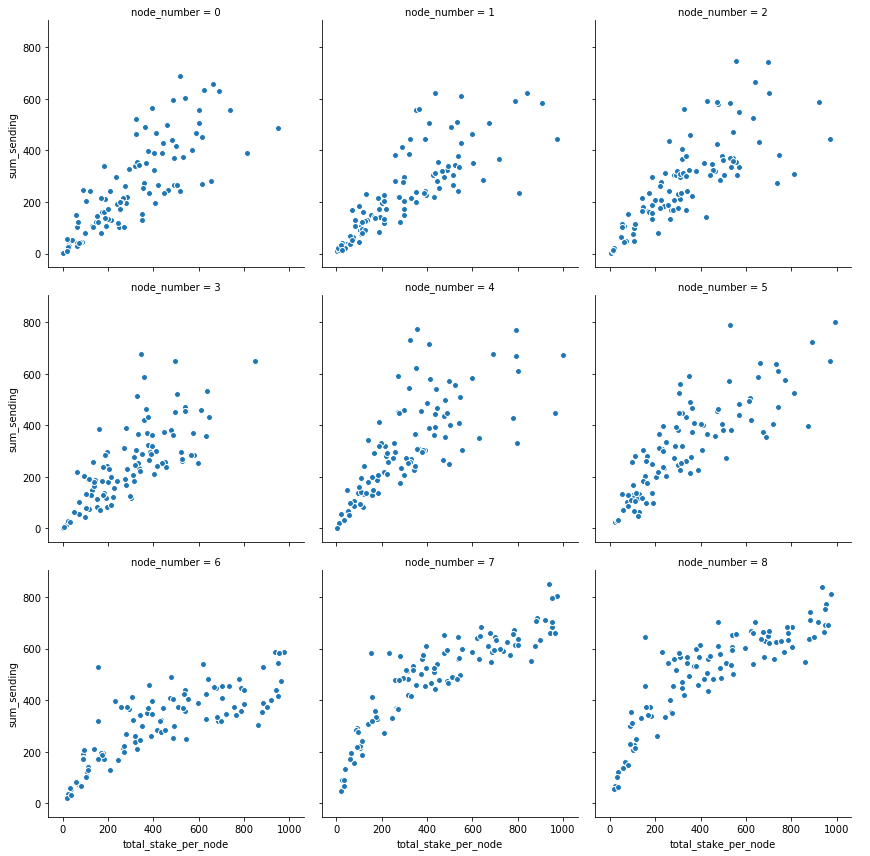

In [26]:
g = sns.FacetGrid(df, col="node_number", height=4, col_wrap=3)
g = (g.map(plt.scatter, "total_stake_per_node", "sum_sending", edgecolor="w").add_legend())

In [29]:
pip install Fitter

  Using cached pexpect-4.8.0-py2.py3-none-any.whl (59 kB)
  Using cached ptyprocess-0.7.0-py2.py3-none-any.whl (13 kB)
  Created wheel for Fitter: filename=fitter-1.4.0-py3-none-any.whl size=25036 sha256=220bcd5d060b856b169bc5ba87776d8766b37e1795da6d415e98819650d1f0f3
  Stored in directory: c:\users\szany\appdata\local\pip\cache\wheels\e1\98\16\e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=586b69906f91942419f00867721c0c17afd55a0ef4efd6dab71d75bf0cef9eec
  Stored in directory: c:\users\szany\appdata\local\pip\cache\wheels\82\ab\83\fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built Fitter easydev
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [31]:
df

,node_number,sum_opening,sum_sending,stake,total_stake_per_node,node_runners,total_stake_per_node_m,sum_sending_m
0,0,41.0,107,410,130.8000000000000113686837722,random,130.800000,107.0
1,1,87.0,228,870,395.4000000000000341060513164,random,395.400000,228.0
2,2,54.0,169,540,267.6000000000000227373675444,random,267.600000,169.0
3,3,71.0,235,710,338.7000000000000170530256583,random,338.700000,235.0
4,4,72.0,228,720,343.2000000000000454747350886,random,343.200000,228.0
...,...,...,...,...,...,...,...,...
994,4,112.0,390,1120,409.0000000000000568434188609,random,409.000000,390.0
995,5,231.0,576,2310,774.0,random,774.000000,576.0
996,6,76.0,283,760,452.7921161102717064750322606,all_in,452.792116,283.0
997,7,140.0,477,1400,452.7921161102717348967416910,equal_spread,452.792116,477.0


In [32]:
df_alter = df[["total_stake_per_node_m", "sum_sending_m"]]

C:\Users\szany\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\szany\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\szany\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determi

,sumsquare_error,aic,bic,kl_div
gausshyper,0.000006,1455.130816,-35066.496467,inf
chi,0.000006,1453.600566,-34978.763001,inf
nakagami,0.000006,1453.600560,-34978.762937,inf
burr,0.000007,1462.401380,-34955.637355,inf
beta,0.000007,1447.572518,-34952.192361,inf


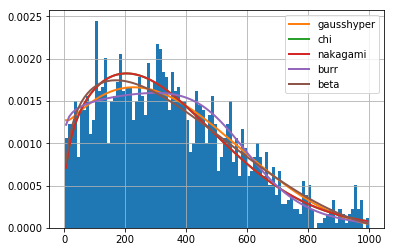

C:\Users\szany\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1618: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\szany\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [33]:
f = Fitter(df_alter)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()